In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import utils4

## Reading in files and indexing them on time

In [49]:
targets_a = pd.read_parquet('../data/A/train_targets.parquet')
targets_b = pd.read_parquet('../data/B/train_targets.parquet')
targets_c = pd.read_parquet('../data/C/train_targets.parquet')
targets_a = targets_a.set_index('time')
targets_b = targets_b.set_index("time")
targets_c = targets_c.set_index("time")


In [50]:
X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')
X_train_observed_a = X_train_observed_a.set_index("date_forecast")
X_train_observed_b = X_train_observed_b.set_index("date_forecast")
X_train_observed_c = X_train_observed_c.set_index("date_forecast")


In [51]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")


In [52]:
X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")


## Some EDA

In [53]:
# Notice that missing rows are simply non-existent for Y_train_a, not filled with NaN or anything
# From 21. october
display(targets_a[29660:29670])

,pv_measurement
time,
2022-10-20 18:00:00,0.0
2022-10-20 19:00:00,0.0
2022-10-20 20:00:00,0.0
2022-10-20 21:00:00,0.0
2022-10-20 22:00:00,0.0
2022-10-20 23:00:00,0.0
2022-10-21 00:00:00,0.0
2022-10-28 22:00:00,0.0
2022-10-28 23:00:00,0.0


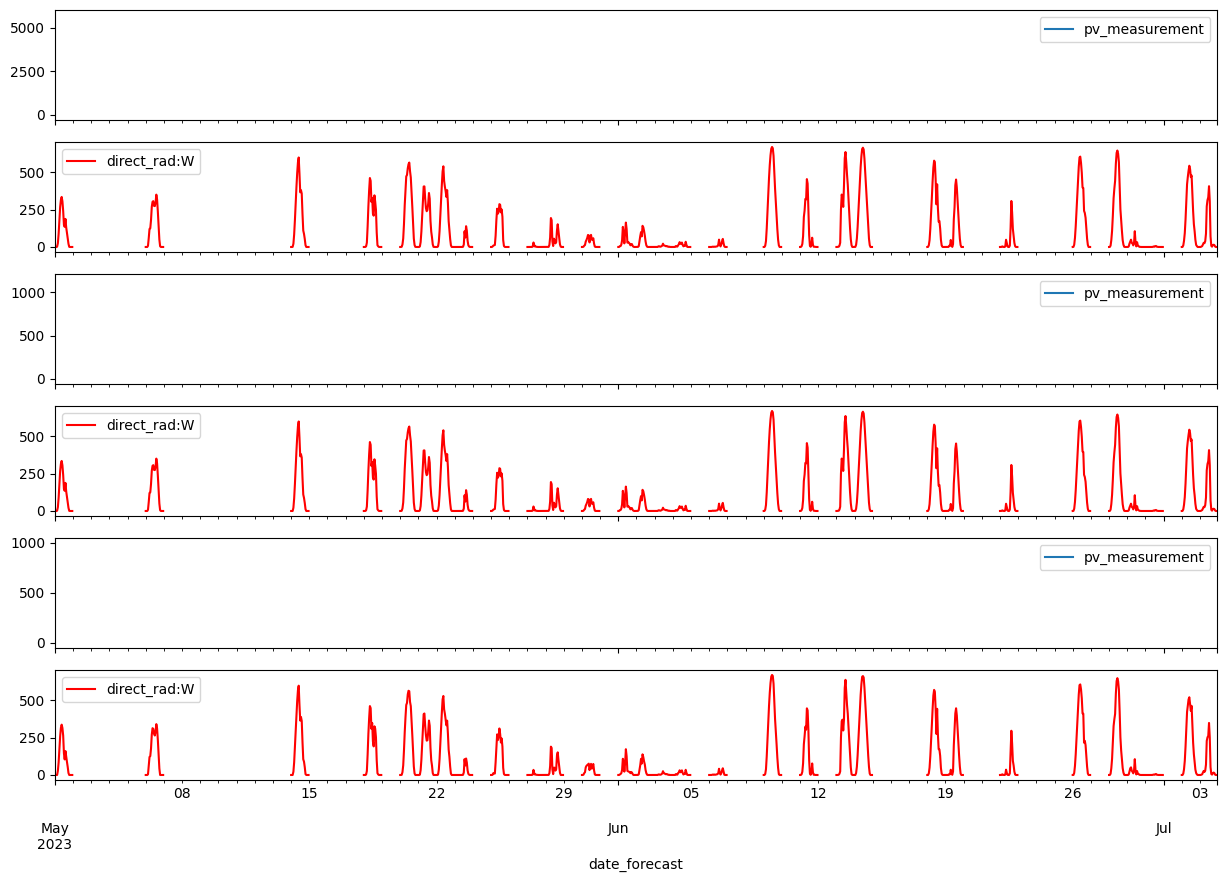

In [54]:
### generalized plotting
start_date = '2019'
end_date = '2024'

feature_name = "direct_rad:W"

Y = [targets_a, targets_b, targets_c]
X = [X_test_estimated_a, X_test_estimated_b, X_test_estimated_c, ]

utils4.plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

## Data Preprocessing

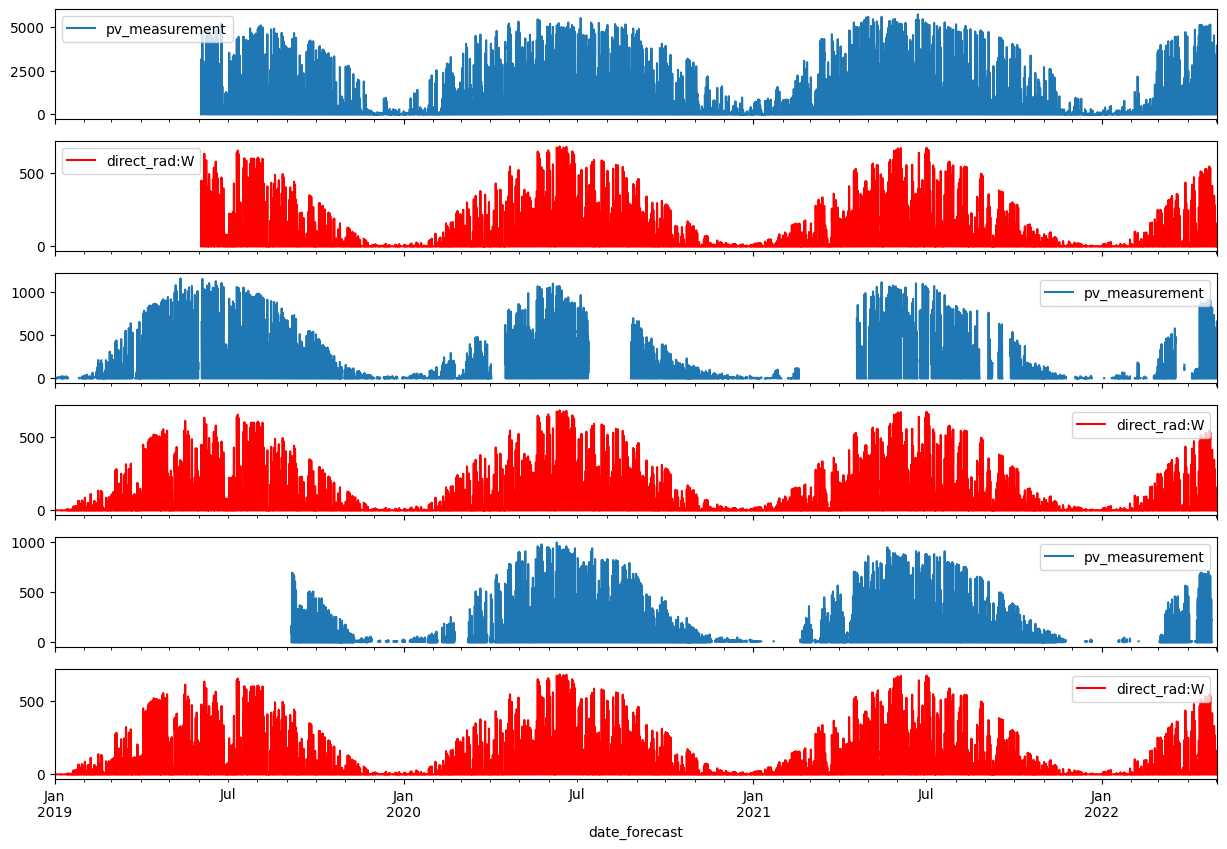

In [55]:
# removing rows where pv_measurment remains the same for more than 18 hours.
targets_a = utils4.remove_constant_values(targets_a, "pv_measurement", 18).dropna()
targets_b = utils4.remove_constant_values(targets_b, "pv_measurement", 18).dropna()
targets_c = utils4.remove_constant_values(targets_c, "pv_measurement", 18).dropna()

Y = [targets_a, targets_b, targets_c]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]

start_date = '2019'
end_date = '2024'
feature_name = "direct_rad:W"

utils4.plot_ts1(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

In [56]:
def create_features(df):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['dayofyear'] = new_df.index.dayofyear
    # new_df = df.copy()
    # new_df['hour'] = new_df.index.hour
    # new_df['dayofweek'] = new_df.index.dayofweek
    # new_df['quarter'] = new_df.index.quarter
    # new_df['month'] = new_df.index.month
    # new_df['year'] = new_df.index.year
    # new_df['dayofyear'] = new_df.index.dayofyear
    # new_df['dayofmonth'] = new_df.index.day
    # new_df['weekofyear'] = new_df.index.isocalendar()[1]
    return new_df

In [57]:
### Adding more time based features to the datasets
X_train_observed_a = create_features(X_train_observed_a)
X_train_observed_b = create_features(X_train_observed_b)
X_train_observed_c = create_features(X_train_observed_c)

X_train_estimated_a = create_features(X_train_estimated_a)
X_train_estimated_b = create_features(X_train_estimated_b)
X_train_estimated_c = create_features(X_train_estimated_c)

X_test_estimated_a = create_features(X_test_estimated_a)
X_test_estimated_b = create_features(X_test_estimated_b)
X_test_estimated_c = create_features(X_test_estimated_c)

In [58]:
### Using only observed weather for training
# Join the y values into x-dataframes for training
train_a = pd.merge(X_train_observed_a, targets_a, left_index=True, right_index=True)
train_b = pd.merge(X_train_observed_b, targets_b, left_index=True, right_index=True)
train_c = pd.merge(X_train_observed_c, targets_c, left_index=True, right_index=True)

In [59]:
def add_lag(df):
    new_df = df.copy()
    

In [60]:
# Check which features most correlated with y
correlations = train_a.corrwith(train_a["pv_measurement"])
for index, corr in correlations.items():
    correlations[index] = abs(corr)

sorted = correlations.sort_values(ascending=False)
best_features = list(sorted[1:10].index)
print(best_features)

['direct_rad:W', 'direct_rad_1h:J', 'clear_sky_rad:W', 'clear_sky_energy_1h:J', 'diffuse_rad:W', 'sun_elevation:d', 'diffuse_rad_1h:J', 'is_in_shadow:idx', 'is_day:idx']


## Create our model

### Select Features

In [61]:
FEATURES = list(train_a.columns[:-1]) # Using all the features of X.
TARGETS = "pv_measurement"

### DATA
X_a = train_a[FEATURES]
y_a = train_a[TARGETS]

X_b = train_b[FEATURES]
y_b = train_b[TARGETS]

X_c = train_c[FEATURES]
y_c = train_c[TARGETS]

### Location A

In [62]:
### Location A

### If using validation set, split the data into training and testing sets 
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_A = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_A.fit(X_train_a, y_train_a,
        eval_set = [(X_train_a, y_train_a), (X_test_a, y_test_a)],
        verbose=100)

# Make predictions on the test data
y_pred_a = reg_A.predict(X_test_a)

y_pred_a = np.clip(y_pred_a, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_a, y_pred_a)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:712.15018	validation_1-mae:715.16230
[100]	validation_0-mae:345.68088	validation_1-mae:349.52726
[200]	validation_0-mae:247.71925	validation_1-mae:252.37404
[300]	validation_0-mae:219.36572	validation_1-mae:226.59995
[400]	validation_0-mae:209.94677	validation_1-mae:218.45014
[500]	validation_0-mae:206.63736	validation_1-mae:216.23496
[600]	validation_0-mae:204.63643	validation_1-mae:215.26168
[700]	validation_0-mae:203.32664	validation_1-mae:214.61887
[800]	validation_0-mae:202.29832	validation_1-mae:214.07758
[900]	validation_0-mae:200.99822	validation_1-mae:213.49678
[999]	validation_0-mae:199.88998	validation_1-mae:212.98950
Mean Absolute Error: 212.9287365732344


### Location B

In [63]:
### Location B

# Split the data into training and testing sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_B = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_B.fit(X_train_b, y_train_b,
        eval_set = [(X_train_b, y_train_b), (X_test_b, y_test_b)],
        verbose=100)

# Make predictions on the test data
y_pred_b = reg_B.predict(X_test_b)

y_pred_b = np.clip(y_pred_b, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_b, y_pred_b)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:136.05422	validation_1-mae:134.00605
[100]	validation_0-mae:63.97105	validation_1-mae:64.82603
[200]	validation_0-mae:42.24871	validation_1-mae:45.01297
[300]	validation_0-mae:35.43512	validation_1-mae:38.92247
[400]	validation_0-mae:33.15052	validation_1-mae:37.21677
[500]	validation_0-mae:32.25206	validation_1-mae:36.50311
[600]	validation_0-mae:31.74674	validation_1-mae:36.18073
[700]	validation_0-mae:31.34903	validation_1-mae:35.98134
[800]	validation_0-mae:31.16980	validation_1-mae:35.89041
[900]	validation_0-mae:30.94073	validation_1-mae:35.79461
[999]	validation_0-mae:30.75839	validation_1-mae:35.71037
Mean Absolute Error: 35.69448817078457


### Location C

In [64]:
### Location C

# Split the data into training and testing sets
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

# Create an XGBoostRegressor with some default hyperparameters
reg_C = xgb.XGBRegressor(
    n_estimators=1000,  
    early_stopping_rounds=100,
    learning_rate=0.01,
    objective='reg:absoluteerror', 
)

# Fit the model on the training data
reg_C.fit(X_train_c, y_train_c,
        eval_set = [(X_train_c, y_train_c), (X_test_c, y_test_c)],
        verbose=100)

# Make predictions on the test data
y_pred_c = reg_C.predict(X_test_c)

y_pred_c = np.clip(y_pred_c, a_min=0, a_max=None)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_c, y_pred_c)

print(f"Mean Absolute Error: {mae}")

[0]	validation_0-mae:117.72326	validation_1-mae:111.87847
[100]	validation_0-mae:56.27225	validation_1-mae:54.11891
[200]	validation_0-mae:36.31723	validation_1-mae:37.07249
[300]	validation_0-mae:30.00741	validation_1-mae:32.47735
[400]	validation_0-mae:28.09910	validation_1-mae:31.12704
[500]	validation_0-mae:27.31388	validation_1-mae:30.62242
[600]	validation_0-mae:26.94367	validation_1-mae:30.42076
[700]	validation_0-mae:26.74167	validation_1-mae:30.33435
[800]	validation_0-mae:26.64367	validation_1-mae:30.28284
[900]	validation_0-mae:26.43791	validation_1-mae:30.19540
[999]	validation_0-mae:26.24498	validation_1-mae:30.13054
Mean Absolute Error: 30.121230012317117


## Analysis

### Feature Importance

In [65]:
fi_a = pd.DataFrame(data=reg_A.feature_importances_,
             index=reg_A.feature_names_in_,
             columns=["importance"])
fi_a.sort_values("importance", ascending=False).head()

,importance
is_in_shadow:idx,0.791385
diffuse_rad:W,0.090381
sun_elevation:d,0.053504
is_day:idx,0.012820
direct_rad:W,0.006503


In [66]:
fi_b = pd.DataFrame(data=reg_B.feature_importances_,
             index=reg_B.feature_names_in_,
             columns=["importance"])
fi_b.sort_values("importance", ascending=False).head()

,importance
is_in_shadow:idx,0.524750
clear_sky_rad:W,0.156992
sun_elevation:d,0.123456
diffuse_rad:W,0.090680
direct_rad:W,0.012200


In [67]:
fi_c = pd.DataFrame(data=reg_C.feature_importances_,
             index=reg_C.feature_names_in_,
             columns=["importance"])
fi_c.sort_values("importance", ascending=False).head()

,importance
diffuse_rad:W,0.328801
sun_elevation:d,0.249741
clear_sky_rad:W,0.184319
direct_rad:W,0.030075
hour,0.025818


### Visualizing the validation sets

<Axes: >

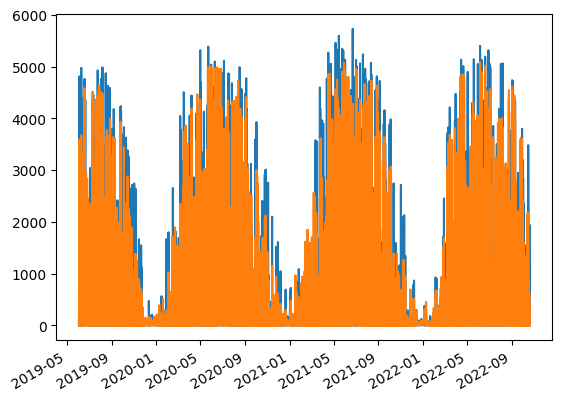

In [68]:
y_test_a.plot()
X_test_a["prediction"] = y_pred_a
X_test_a["prediction"].plot()

<Axes: >

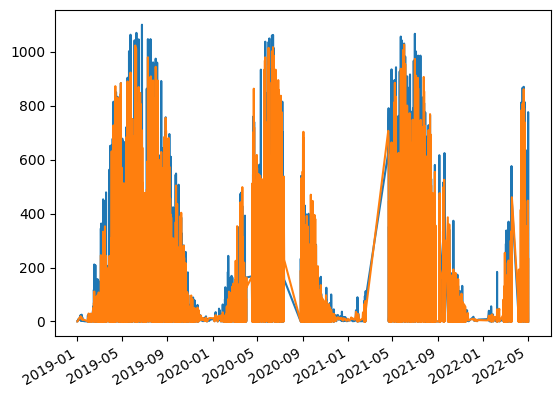

In [69]:
y_test_b.plot()
X_test_b["prediction"] = y_pred_b
X_test_b["prediction"].plot()

<Axes: >

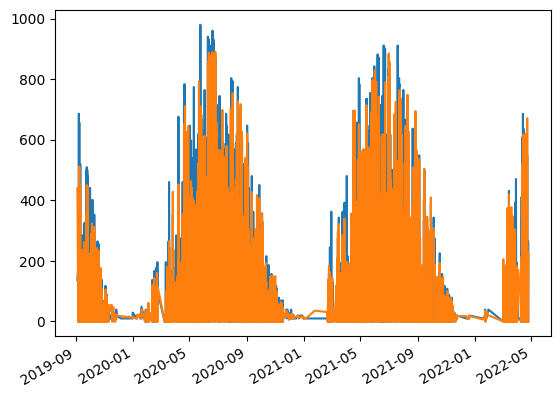

In [70]:
y_test_c.plot()
X_test_c["prediction"] = y_pred_c
X_test_c["prediction"].plot()

### Using the weather forecast part of the training data as a dummy unseen test set

2023-04-28 11:00:00    3380.666621
2023-04-28 12:00:00    3284.481836
2023-04-28 10:00:00    2802.069062
2023-03-23 13:00:00    2729.845977
2023-03-20 11:00:00    2550.840015
Name: error, dtype: float64

Mean Absolute Error: 135.53911501567603
MAE for the last 1000 values: 274.5735283478582


<Axes: >

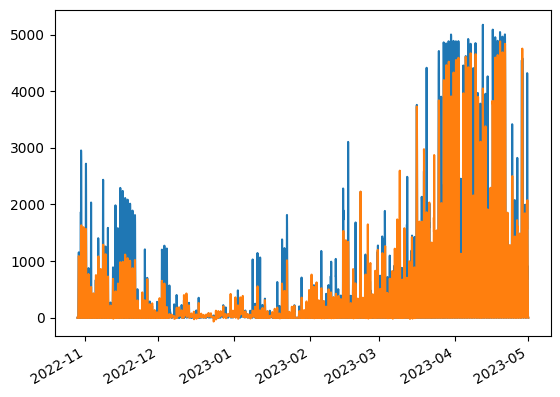

In [71]:
df = X_train_estimated_a[FEATURES]
df["prediction"] = reg_A.predict(X_train_estimated_a[FEATURES])

df = pd.merge(df, targets_a, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot() 

2023-04-28 11:00:00    602.995202
2023-04-28 12:00:00    560.038767
2023-04-08 11:00:00    526.690430
2023-04-30 12:00:00    508.817766
2023-04-28 10:00:00    463.758791
Name: error, dtype: float64

Mean Absolute Error: 18.903913015583125
MAE for the last 1000 values: 38.94126540778867


<Axes: >

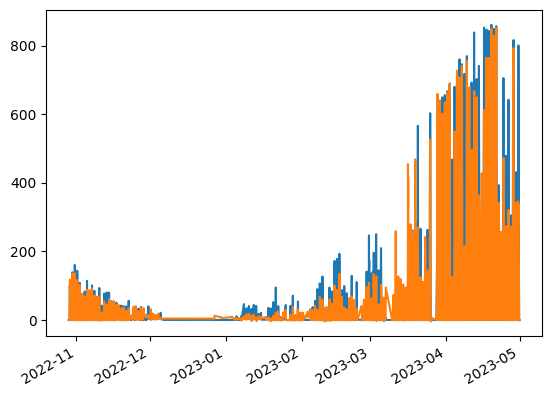

In [72]:
df = X_train_estimated_b[FEATURES]
df["prediction"] = reg_B.predict(X_train_estimated_b[FEATURES])

df = pd.merge(df, targets_b, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

print(f"Mean Absolute Error: {mae}")

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot()

2023-03-19 10:00:00    374.276132
2023-03-27 12:00:00    358.908188
2023-03-27 11:00:00    358.213096
2023-04-07 09:00:00    344.097211
2023-04-14 11:00:00    329.881946
Name: error, dtype: float64

Mean Absolute Error: 25.30059043571114
MAE for the last 1000 values: 46.20392688697816


<Axes: >

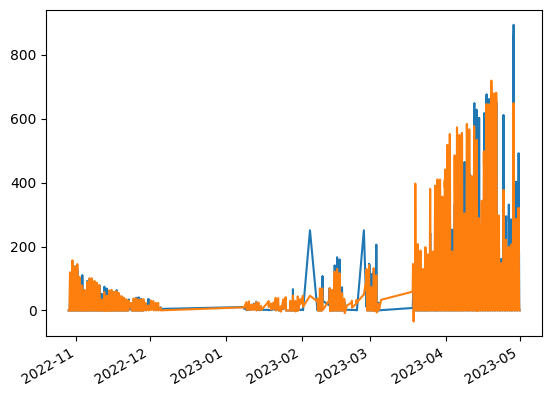

In [73]:
df = X_train_estimated_c[FEATURES]
df["prediction"] = reg_C.predict(X_train_estimated_c[FEATURES])

df = pd.merge(df, targets_c, left_index=True, right_index=True)

df["error"] = np.abs(df["pv_measurement"] - df["prediction"])
display(df["error"].sort_values(ascending=False).head())

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(df["pv_measurement"], df["prediction"])
print(f"Mean Absolute Error: {mae}")

# Assuming df is your DataFrame
last_1000_values_df = df.tail(1000)

mae_last = mean_absolute_error(last_1000_values_df["pv_measurement"], last_1000_values_df["prediction"])
print("MAE for the last 1000 values:", mae_last)

df["pv_measurement"].plot()
df["prediction"].plot()


## Predicting on the actual test set

In [74]:
### Location B
X_test_estimated_a = X_test_estimated_a[FEATURES]
A_pred = reg_A.predict(X_test_estimated_a)
A_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(A_pred), 4):
    A_pred_hourly.append(A_pred[i])
    

In [75]:
### Location B
X_test_estimated_b = X_test_estimated_b[FEATURES]
B_pred = reg_B.predict(X_test_estimated_b)
B_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(B_pred), 4):
    B_pred_hourly.append(B_pred[i])

In [76]:
   
### Location C
X_test_estimated_c = X_test_estimated_c[FEATURES]
C_pred = reg_C.predict(X_test_estimated_c)
C_pred_hourly = []

# just taking the value every whole hour
for i in range(0, len(C_pred), 4):
    C_pred_hourly.append(C_pred[i])  

### Visualizing how the model predicts on the actual test set

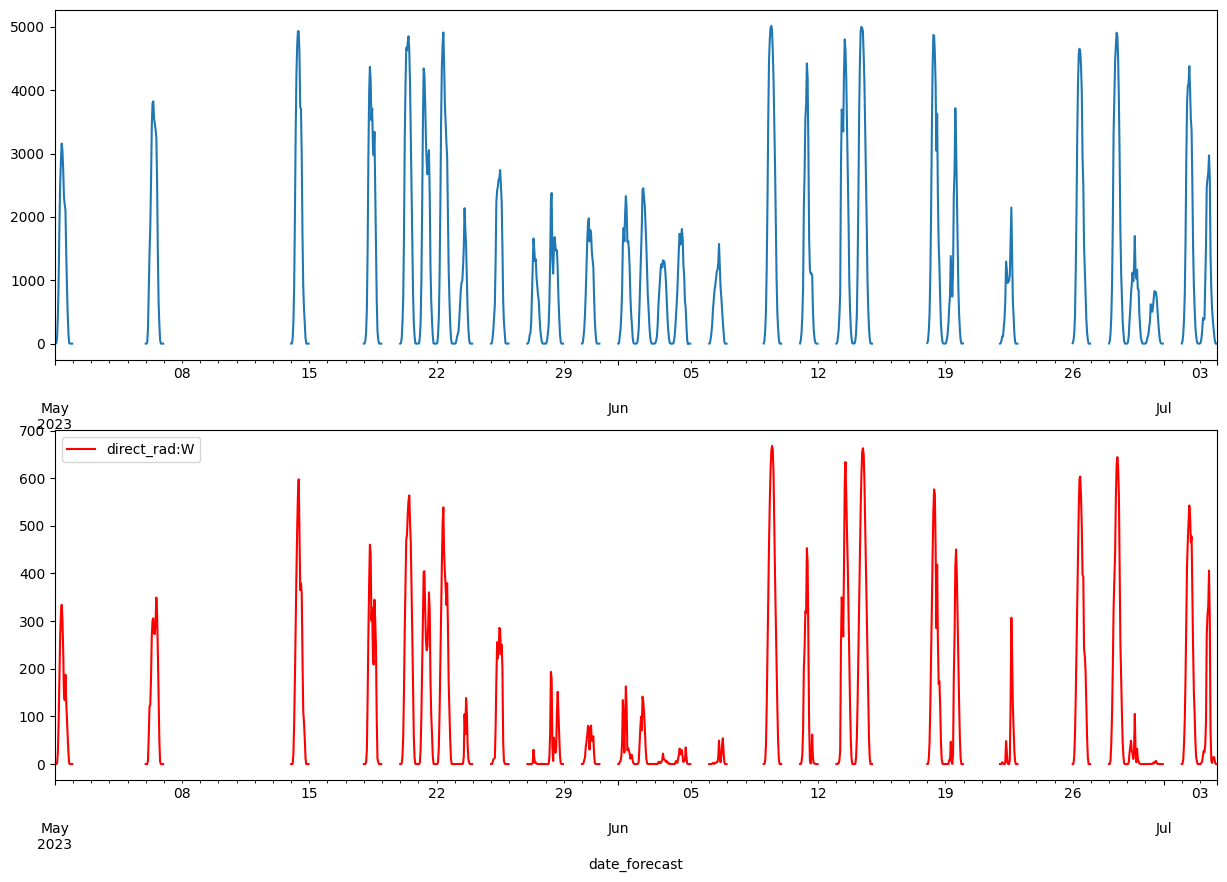

In [77]:
df = X_test_estimated_a.copy()
df["prediction"] = reg_A.predict(X_test_estimated_a[FEATURES])

start = "05-2023"
end = "08-2023"
feature = "direct_rad:W"

utils4.plot_ts1([df["prediction"]], [df], start, end, feature, shareX=False)



## Storing the predictions

In [78]:
predictions = np.concatenate([A_pred_hourly, B_pred_hourly, C_pred_hourly])
# remove negative and small positive predictions
predictions = np.where(predictions < 0.05, 0, predictions)
ids = range(len(predictions))
df = pd.DataFrame({"id": ids, "prediction": predictions})
df.to_csv("saves/xgboost4.csv", index=False)